# Selection Bias





In [1]:
#%load_ext autoreload
#%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az
import preliz as pz

import xarray as xr
import pytensor.tensor as pt 

from utils import value_counts, decorate

from scipy.special import expit


In [3]:
# Make the figures smaller to save some screen real estate
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6, 3.5]
plt.rcParams["axes.titlelocation"] = "left"

## SAT Data

Boys who take the SAT get higher math scores than girls, and the difference is consistent.
In data published by the College Board for 2001-2015, the differences were 31, 34, 32, 31, and 31 points.

Reasons for this difference are a topic of debate. They include

* Boys are better at math, on average.

* Boys are better at taking the SAT, so the difference in scores overstates the difference in efficacy.

* Boys who are bad at math are less likely to take the SAT than girls with the same efficacy -- due to this selection bias, the difference in scores overstates the difference in efficacy.

These articles are examples of the debate:

* Mark J. Perry asserts that ["2016 SAT Test Results Confirm Pattern That’s Persisted for 50 Years — High School Boys Are Better at Math Than Girls"](https://www.aei.org/carpe-diem/2016-sat-test-results-confirm-pattern-thats-persisted-for-45-years-high-school-boys-are-better-at-math-than-girls/).

* Wendy Morrison and Grace Finley contend, ["Actually, SAT Results Don’t Confirm Boys Are Better at Math Than Girls"](https://www.aei.org/economics/sat-results-dont-confirm-boys-better-at-math-than-girls/), and they offer alternative explanations for the difference in scores.

* And Perry responds, ["Actually, 50 Years of Test Scores DO Confirm That Boys Outperform Girls on the SAT Math Test"](https://www.aei.org/carpe-diem/actually-50-years-of-test-scores-do-confirm-that-boys-outperform-girls-on-the-sat-math-test/), and explains why he finds the argument for a sampling effect unconvincing.

If it's true that boys with low math efficacy are less likely to take the SAT, we should see evidence of this effect in the distributions of scores, and we may be able to estimate the magnitude of the effect, and what fraction of the difference in scores we observe. 

As data, we'll use distributions of scores reported here:

2011 math: https://secure-media.collegeboard.org/digitalServices/pdf/SAT-Mathemathics_Percentile_Ranks_2011.pdf

2012 math: https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Mathemathics-Percentile-Ranks-2012.pdf

2013 math: https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Mathematics-Percentile-Ranks-2013.pdf

2014 math: https://web.archive.org/web/20160402182221/https://secure-media.collegeboard.org/digitalServices/pdf/sat/sat-percentile-ranks-mathematics-2014.pdf

2015 math: https://web.archive.org/web/20211222094405/https://secure-media.collegeboard.org/digitalServices/pdf/sat/sat-percentile-ranks-mathematics-2015.pdf

Data for the writing section, and composite scores are also available for some years


2011 writing: https://secure-media.collegeboard.org/digitalServices/pdf/SAT-Writing_Percentile_Ranks_2011.pdf

2011 composite: https://secure-media.collegeboard.org/digitalServices/pdf/SAT-Percentile-Ranks-Composite-CR-M-W-2011.pdf

2011 reading+math: https://secure-media.collegeboard.org/digitalServices/pdf/SAT-Percentile-Ranks-Composite-CR-M_2011.pdf

2012 reading: https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Critical-Reading-Percentile-Ranks-2012.pdf

2012 composite: https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Percentile-Ranks-Composite-CR-M-W-2012.pdf

2012 reading+math: https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Percentile-Ranks-Composite-CR-M-2012.pdf

2013 composite: https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Percentile-Ranks-Composite-CR-M-W-2013.pdf

2013 reading+math https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Percentile-Ranks-Composite-CR-M-2013.pdf

https://secure-media.collegeboard.org/digitalServices/pdf/research/SAT-Percentile-Ranks-Composite-CR-M-W-2013.pdf



We used a PDF parser to extract the data from the PDF files, and the following function to read the resulting CSV files.

In [4]:
def read_sat_math(year):
    df = pd.read_csv(f'sat_math_{year}.csv', index_col=0)
    df.columns = [f'Total', 'Male', 'Female']
    return df

The following dictionary maps from each year (2011-2015) to a Pandas `DataFrame`.

In [5]:
df_map = {}
years = range(2011, 2016)
for year in years:
    df_map[year] = read_sat_math(year)

Here are the total number of test takers in each year.

In [6]:
df_map[2011].sum()

Total     1647123
Male       770605
Female     876518
dtype: int64

In [7]:
df_map[2012].sum()

Total     1664479
Male       778142
Female     886337
dtype: int64

In [8]:
df_map[2013].sum()

Total     1660047
Male       776092
Female     883955
dtype: int64

In [9]:
df_map[2014].sum()

Total     1672395
Male       783570
Female     888825
dtype: int64

In [10]:
df_map[2015].sum()

Total     1698521
Male       794802
Female     903719
dtype: int64

In every year, substantially more girls than boys took the SAT, which is evidence that the selection effect is stronger for boys.

TODO: Get data on the number of boys and girls alive at test-taking age and the number who were enrolled in high school.

The following function converts the number of test-takers with each score into a normalized PMF.

In [11]:
from empiricaldist import Pmf

def make_pmf(df, col):
    pmf = Pmf(df[col])
    pmf.normalize()
    return pmf

Comparing the distribution of scores across years, we can see that the location and spread of the distributions appears consistent.

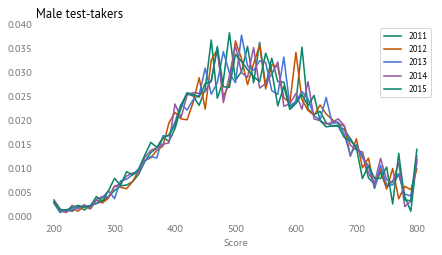

In [12]:
for year, df in df_map.items():
    pmf = make_pmf(df, 'Male')
    pmf.plot(label=year)

decorate(title='Male test-takers')

And likewise for female test takers.

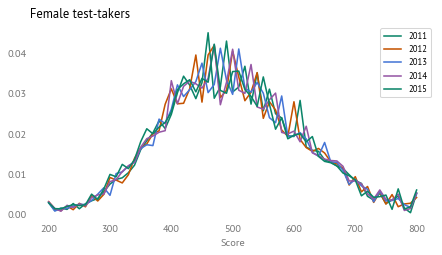

In [13]:
for year, df in df_map.items():
    pmf = make_pmf(df, 'Female')
    pmf.plot(label=year)

decorate(title='Female test-takers')

It is notable that the distributions are spiky.
These perturbations are the result of the way SAT scores are computed.
During 2011-2015 the math section of the SAT typically had 44 multiple choice questions and 10 grid questions.
For the multiple-choice questions, incorrect answers were penalized by 1/4 point.
In each year, some combinations of correct, incorrect, and blank responses were more likely than others.
As a result, the PMF for each year shows a pattern of perturbations that is consistent for male and female test-takers, as shown in the following plots.

In [14]:
def compare_spikes(df_map, year):
    pmf_male = make_pmf(df_map[year], 'Male')
    pmf_male.plot(label='Male')
    
    pmf_female = make_pmf(df_map[year], 'Female')
    pmf_female.plot(label='Female')
    
    mean_male = pmf_male.mean()
    mean_female = pmf_female.mean()
    print(f'Male={mean_male}, Female={mean_female}, Diff={mean_male - mean_female}')
    decorate(title=year)

Male=531.0491886245221, Female=499.6034993006419, Diff=31.44568932388023


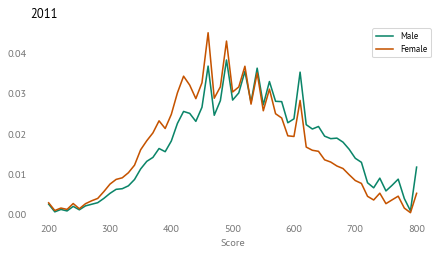

In [15]:
compare_spikes(df_map, 2011)

Male=532.3130225588645, Female=498.5023529425038, Diff=33.81066961636071


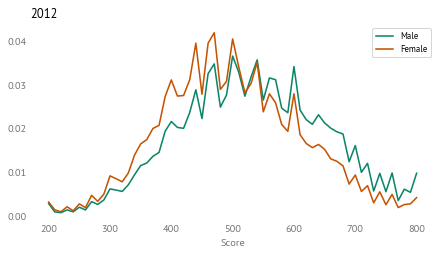

In [16]:
compare_spikes(df_map, 2012)

Male=530.910871391536, Female=499.4024808955207, Diff=31.508390496015352


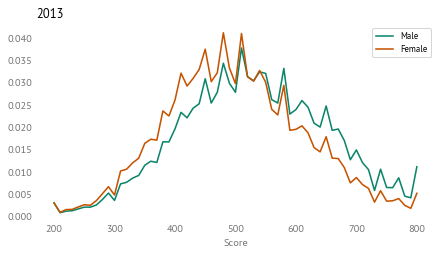

In [17]:
compare_spikes(df_map, 2013)

Male=529.823844710747, Female=498.5317582201221, Diff=31.292086490624968


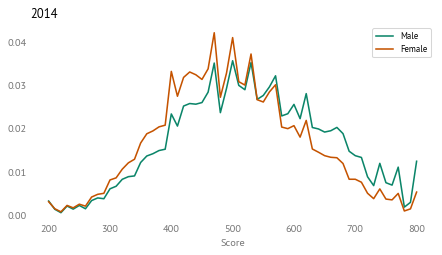

In [18]:
compare_spikes(df_map, 2014)

Male=527.1939174788187, Female=495.92306900706967, Diff=31.27084847174899


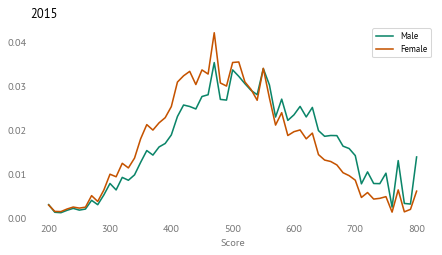

In [19]:
compare_spikes(df_map, 2015)

It is also notable that the extreme scores (200 and 800) are overrepresented, which suggests that test scores don't reflect the full range of efficacy.

In [20]:
years = [2011, 2012, 2013, 2014, 2015]
sexes = ['Male', 'Female']

rows = []
for year in years:
    for sex in sexes:
        df = df_map[year]
        pmf = make_pmf(df, sex)
        rows.append((year, sex, pmf.mean(), pmf.std()))
        
summary = pd.DataFrame(rows, columns=['Year', 'Sex', 'Mean', 'Std'])

We'll use the following function later to plot the relationship between a potential score and the probability of taking the SAT.

In [21]:
def plot_selection_function(idata, col, thetas_centered, **options):
    thetas_xr = xr.DataArray(thetas_centered, dims="theta", coords={"theta": thetas})

    # Extract posterior samples of alpha and beta ---
    posterior = idata.posterior  # shape (chain, draw)

    # Compute logits and apply sigmoid ---
    # logits = posterior["alpha"] + posterior["beta"] * thetas_xr
    logits = posterior["beta"] * thetas_xr
    p = xr.apply_ufunc(expit, logits)

    # Compute median and HDI ---
    median_curve = p.median(dim=["chain", "draw"])
    hdi_bounds = az.hdi(p, hdi_prob=0.94)
    low, high = hdi_bounds['x'].T

    # Plot ---
    plt.plot(thetas, median_curve, **options)
    plt.fill_between(
        thetas,
        low,
        high,
        alpha=0.3,
    )    

## Simple Model

As a first step, we'll build a model that takes data from one year and estimates:

* The mean and standard deviation of a latent distribution of efficacy. We'll use "efficacy" to mean the ability to answer test questions correctly, which involves some combination of aptitude, achievement, and acumen.

* The parameters of a selection function that relates efficacy to the probability of taking the test.

* The perturbations of the distribution of test scores.

To model the excess of scores at the extremes, we'll assume that the latent distribution of efficacy extends from 100 to 900 -- that is, beyond the range of SAT scores by 100 points at both ends.

In [22]:
full_thetas = np.arange(100, 910, 10)
full_thetas

array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220,
       230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350,
       360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480,
       490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610,
       620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740,
       750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870,
       880, 890, 900])

We'll use these masks to select the center part of the distribution, with valid SAT scores, and the tails.

In [23]:
left_mask = full_thetas < 200
right_mask = full_thetas > 800
center_mask = (full_thetas >= 200) & (full_thetas <= 800)

In [24]:
thetas = full_thetas[center_mask]
thetas

array([200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320,
       330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450,
       460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580,
       590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710,
       720, 730, 740, 750, 760, 770, 780, 790, 800])

To fit the model, we'll center and scale the scores to the range from -3 to 3.

In [25]:
thetas_centered = thetas - 500
thetas_centered

array([-300, -290, -280, -270, -260, -250, -240, -230, -220, -210, -200,
       -190, -180, -170, -160, -150, -140, -130, -120, -110, -100,  -90,
        -80,  -70,  -60,  -50,  -40,  -30,  -20,  -10,    0,   10,   20,
         30,   40,   50,   60,   70,   80,   90,  100,  110,  120,  130,
        140,  150,  160,  170,  180,  190,  200,  210,  220,  230,  240,
        250,  260,  270,  280,  290,  300])

In [26]:
scale = 100
thetas_scaled = thetas_centered / scale
np.min(thetas_scaled), np.max(thetas_scaled), 

(np.float64(-3.0), np.float64(3.0))

As an example, we'll run the model for a single year and sex.

Note: We'll use the "sex" to refer to the binary categories reported by the College Board. These categories may not reflect the gender identity of the test takers.

In [27]:
year = 2015
sex = 'Male'
counts_obs = df_map[year].loc[thetas, sex]
counts_obs

Score
200     2456
210     1071
220      995
230     1426
240     1779
       ...  
760     2004
770    10434
780     2673
790     2563
800    11098
Name: Male, Length: 61, dtype: int64

In [28]:
N_test = int(counts_obs.sum())
N_test

794802

The parameter `beta` estimates the strength of the selection affect.
As a prior, we'll use a gamma distribution, which is positive valued, reflecting the expectation that if a selection effect exists, people with higher scores are *more* likely to take the test.
The high density interval of the prior is chosen to be weakly informative -- that is, it does not substantially affect the results.

{'alpha': np.float64(4.300178987723759), 'beta': np.float64(83.84212820172407)}

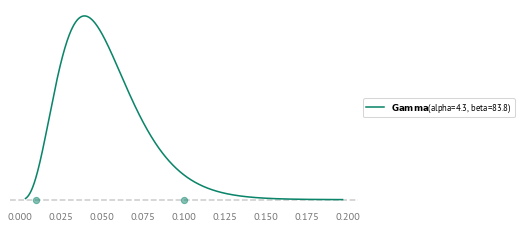

In [29]:
dist, plot = pz.maxent(pz.Gamma(), lower=0.01, upper=0.1, mass=0.95)
beta_params = dist.params_dict
beta_params

For the standard deviation of efficacy, we also use a gamma distribution, with a high density  interval wide enough to cover all likely values.

{'alpha': np.float64(463.6083812559706),
 'beta': np.float64(4.2172887180676595)}

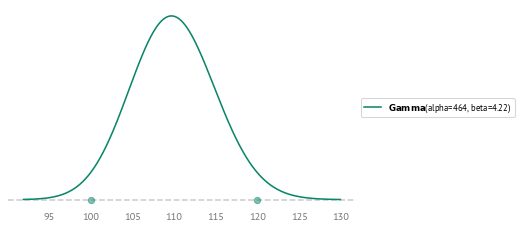

In [30]:
dist, plot = pz.maxent(pz.Gamma(), lower=100, upper=120, mass=0.95)
sigma_params = dist.params_dict
sigma_params

A key parameter of the model is `sigma_noise`, which controls the magnitude of the perturbations to the distribution of efficacy.
If it's too small, it restricts the spikes too much, and the model fails the posterior predictive check -- the generated data is smoother than the real data.
If it's too large, it allows the perturbations to explain the shape of the distribution entirely, so we lose the ability to estimate the difference in latent distributions and the magnitude of the selection effect.

By trial and error, 0.05 seems to be the smallest value that's sufficient to reproduce the spikes, while preserving the ability to estimate the other parameters.

{'alpha': np.float64(7.322722507058703), 'beta': np.float64(63.49200942322235)}

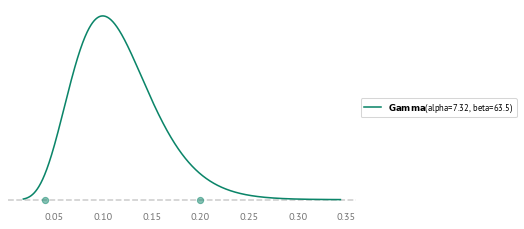

In [31]:
dist, plot = pz.maxent(pz.Gamma(), lower=0.04, upper=0.2, mass=0.95)
sigma_noise_params = dist.params_dict
sigma_noise_params

Now here's the model.

In [32]:
def make_model(N_test, counts_obs):
    with pm.Model() as model:
        # Latent efficacy distribution
        mu = pm.Normal("mu", mu=500, sigma=30)
        sigma = pm.Gamma("sigma", **sigma_params)
        
        # Prior for the parameter of the selection effect
        beta = pm.Gamma("beta", **beta_params)

        # Compute log PDF of the hypothetical distribution of efficacy
        log_pdf = pm.logp(pm.Normal.dist(mu=mu, sigma=sigma), full_thetas)

        # Generate perturbations in the center region
        sigma_noise = pm.Gamma("sigma_noise", **sigma_noise_params)
        log_noise_raw = pm.ZeroSumNormal("log_noise_raw", sigma=sigma_noise, 
                                         shape=(len(thetas),))

        # --- Detrend log_noise ---
        # slope = (x·y) / (x·x)
        x = thetas_scaled
        slope = pm.math.dot(log_noise_raw, x) / pm.math.dot(x, x)
        log_noise = pm.Deterministic("log_noise", log_noise_raw - slope * x)

        # Perturb the distribution
        perturbed_log_pdf = pt.inc_subtensor(log_pdf[center_mask], log_noise)
        
        # Normalize and convert to probabilities
        normalizer = pm.math.logsumexp(perturbed_log_pdf)
        pdf = pm.Deterministic("pdf", pm.math.exp(perturbed_log_pdf - normalizer))

        # Roll up the tail probabilities
        left_mass = pdf[left_mask].sum()
        right_mass = pdf[right_mask].sum()
        center_pdf = pdf[center_mask]

        # Add the tail probabilities to the extreme scores
        center_pdf = pt.inc_subtensor(center_pdf[0], left_mass)
        center_pdf = pt.inc_subtensor(center_pdf[-1], right_mass)

        # Selection model (linear on logit scale)
        logits = beta * thetas_scaled
        p_take = pm.Deterministic("p_take", pm.math.sigmoid(logits))

        # Test-taker distribution
        test_unnorm = center_pdf * p_take
        test_pdf = test_unnorm / pm.math.sum(test_unnorm)

        # Multinomial likelihood for binned scores
        pm.Multinomial("obs_bins", n=N_test, p=test_pdf, observed=counts_obs)
        
    return model


Here's a sample from the prior distributions.

In [33]:
model = make_model(N_test, counts_obs)

with model:
    prior = pm.sample_prior_predictive(1000)

Sampling: [beta, log_noise_raw, mu, obs_bins, sigma, sigma_noise]


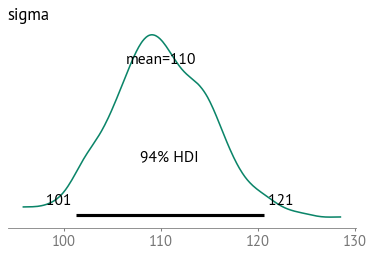

In [34]:
az.plot_posterior(prior, group='prior', var_names=['sigma']);

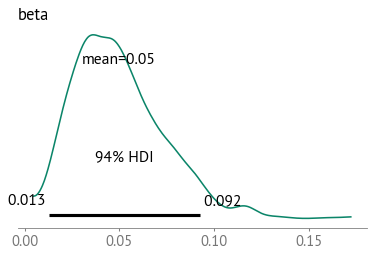

In [35]:
az.plot_posterior(prior, group='prior', var_names=['beta']);

And here's how we fit the model.

In [36]:
with model:
    idata = pm.sample(target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, beta, sigma_noise, log_noise_raw]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


The model samples well and the diagnostics look good.

In [37]:
pm.summary(idata, var_names=['mu', 'sigma', 'beta', 'sigma_noise'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,525.893,1.698,522.688,528.920,0.071,0.047,593.0,885.0,1.01
sigma,119.826,0.811,118.418,121.430,0.071,0.033,137.0,354.0,1.05
beta,0.048,0.023,0.010,0.092,0.001,0.001,801.0,952.0,1.01
sigma_noise,0.235,0.020,0.199,0.271,0.001,0.000,1005.0,1567.0,1.00


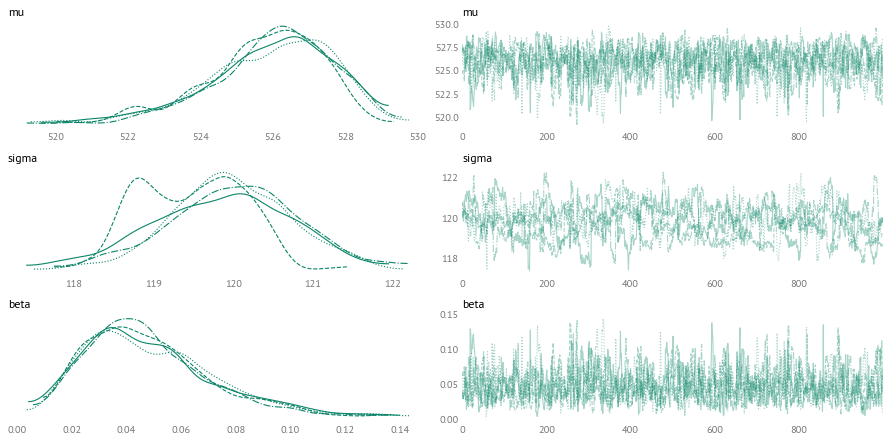

In [38]:
pm.plot_trace(idata, var_names=['mu', 'sigma', 'beta'])
decorate()
plt.savefig("selection_bias19.png",dpi=300)

Here are the posterior distributions.

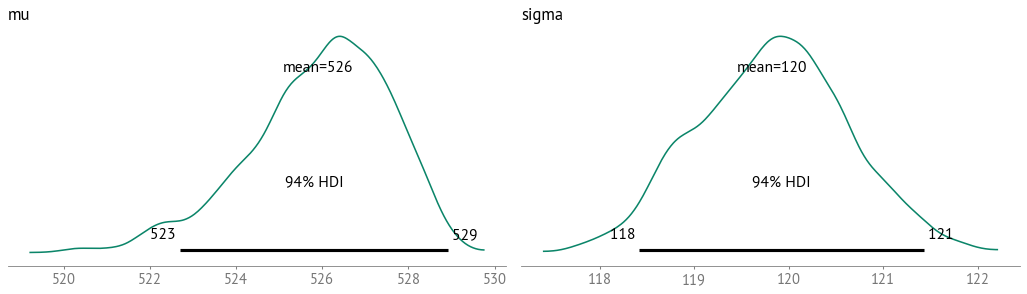

In [39]:
pm.plot_posterior(idata, var_names=['mu', 'sigma'])
decorate()
plt.savefig("selection_bias20.png", dpi=300)

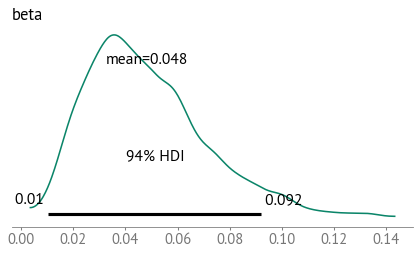

In [40]:
pm.plot_posterior(idata, var_names=['beta'])
decorate()
plt.savefig("selection_bias21.png",dpi=300)

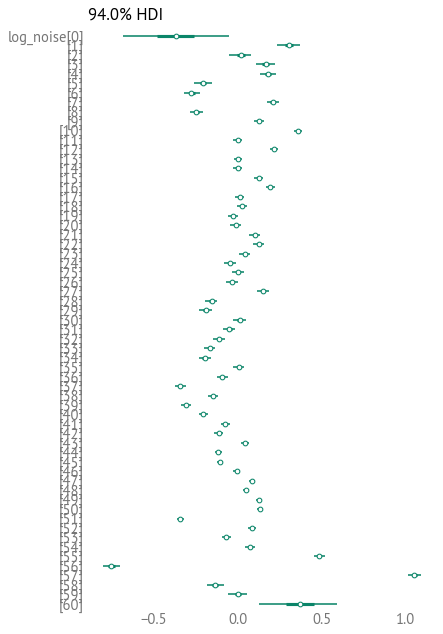

In [41]:
az.plot_forest(idata, var_names='log_noise', combined=True);

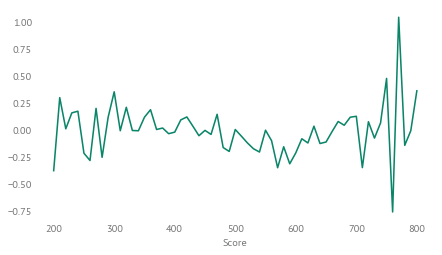

In [42]:
log_noise = np.median(az.extract(idata)['log_noise'], axis=1)
plt.plot(thetas, log_noise)
decorate(xlabel='Score')
plt.savefig("selection_bias22.png",dpi=300)

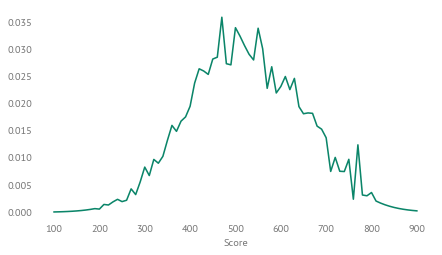

In [43]:
pdf = np.median(az.extract(idata)['pdf'], axis=1)
plt.plot(full_thetas, pdf)
decorate(xlabel='Score')
plt.savefig("selection_bias23.png", dpi=300)

Here's what the selection function looks like, indicating the *relative* probability of taking the test for a range of potential scores.
These probabilities are scaled so the midpoint is 50%.
The left side indicates how much less likely someone is to take the test if their potential score is low.

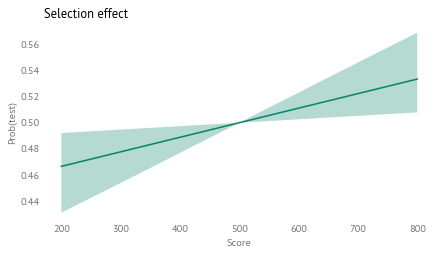

In [44]:
plot_selection_function(idata, 'sat_math', thetas_scaled)
decorate(xlabel='Score', ylabel='Prob(test)', title='Selection effect')
plt.savefig("selection_bias24.png", dpi=300)

To see how reliable this estimate is, let's run a parameter recovery test.

## Posterior predictive check

In [45]:
with model:
    post_pred = pm.sample_posterior_predictive(idata)

Sampling: [obs_bins]


Output()

In [46]:
obs_bins_post_pred = az.extract(post_pred, group='posterior_predictive')['obs_bins']
obs_bins_post_pred.shape

(61, 4000)

In [47]:
medians = np.median(obs_bins_post_pred, axis=-1)
medians.shape

(61,)

In [48]:
hdi_bounds = az.hdi(post_pred['posterior_predictive']['obs_bins'], hdi_prob=0.94)
low, high = hdi_bounds['obs_bins'].T

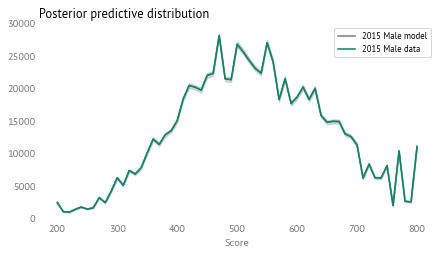

In [49]:
color_map = {'Male': 'C0', 'Female': 'C1'}

plt.fill_between(
    thetas,
    low,
    high,
    color='gray',
    alpha=0.3,
)   
plt.plot(thetas, medians, color='gray', label=f'{year} {sex} model')

df_map[year][sex].plot(color=color_map[sex], label=f'{year} {sex} data')

decorate(title='Posterior predictive distribution')
plt.savefig("selection_bias25.png", dpi=300)

## Parameter recovery

We'll use the following function to generate data given known parameters.

In [50]:
def generate_with_pymc(
    N_test, true_mu, true_sigma, true_beta, true_log_noise, random_seed=123
):
    with pm.Model() as gen:
        # Fixed “true” parameters as constants (no uncertainty)
        mu = pm.Data("mu", true_mu)
        sigma = pm.Data("sigma", true_sigma)
        beta = pm.Data("beta", true_beta)
        log_noise = pm.Data("log_noise", true_log_noise)

        # Compute perturbed log population PDF
        log_pdf = pm.logp(pm.Normal.dist(mu=mu, sigma=sigma), full_thetas)
        perturbed_log_pdf = pt.inc_subtensor(log_pdf[center_mask], log_noise)
        
        normalizer = pm.math.logsumexp(perturbed_log_pdf)
        pdf = pm.Deterministic("pdf", pm.math.exp(perturbed_log_pdf - normalizer))

        # tails → center
        left_mass  = pdf[left_mask].sum()
        right_mass = pdf[right_mask].sum()
        center_pdf = pdf[center_mask]
        center_pdf = pt.inc_subtensor(center_pdf[0], left_mass)
        center_pdf = pt.inc_subtensor(center_pdf[-1], right_mass)

        # selection
        logits = beta * thetas_scaled
        p_take = pm.Deterministic("p_take", pm.math.sigmoid(logits))

        # test-taker score distribution
        test_unnorm = center_pdf * p_take
        test_pdf = pm.Deterministic("test_pdf", test_unnorm / test_unnorm.sum())

        # generate synthetic data
        obs_bins = pm.Multinomial("obs_bins", n=N_test, p=test_pdf)

        prior_pred = pm.sample_prior_predictive(
            draws=1,
            var_names=["obs_bins", "test_pdf", "p_take", "pdf"],
            random_seed=random_seed,
        )
        return prior_pred

As an example, we'll test it with parameters based on the previous example.

In [51]:
N_test = 800_000
true_mu = 526
true_sigma = 124
true_beta = 0.018
true_log_noise = log_noise

prior_pred = generate_with_pymc(
    N_test, true_mu, true_sigma, true_beta, true_log_noise, random_seed=4
)

Sampling: [obs_bins]


In [52]:
counts_draw = prior_pred.prior["obs_bins"].values.squeeze()
counts_draw

array([ 3456,  1442,  1217,  1817,  2194,  1801,  2007,  3734,  2817,
        4789,  7088,  5727,  7974,  7522,  8310, 10739, 13032, 12190,
       13473, 13980, 15745, 18708, 20850, 20319, 19636, 21803, 22186,
       27436, 21278, 20968, 26350, 24899, 23764, 22343, 21570, 25902,
       23469, 17852, 20756, 17306, 18147, 19432, 18222, 19644, 15586,
       14823, 14567, 14863, 13071, 12956, 11714,  6284,  8547,  6532,
        6474,  8722,  2098, 11380,  2815,  2745, 12929])

And we can confirm that the generated data resembles the actual data it is based on.

527.1939174788187


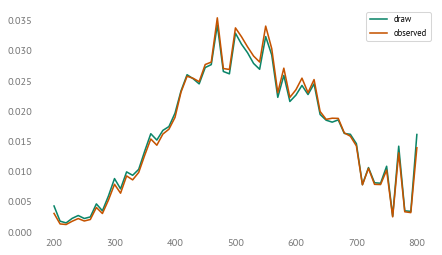

In [53]:
pmf = Pmf(counts_draw, thetas)
pmf.normalize()
pmf.plot(label='draw')

pmf = Pmf(counts_obs, thetas)
pmf.normalize()
pmf.plot(label='observed')

pmf.normalize()
print(pmf.mean())
decorate()
plt.savefig("selection_bias26.png", dpi=300)

Now let's run the model on the generated data.

In [54]:
model = make_model(N_test, counts_draw)

with model:
    idata = pm.sample(target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, beta, sigma_noise, log_noise_raw]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


The diagnostics are good.

In [55]:
pm.summary(idata, var_names=['mu', 'sigma', 'beta', 'sigma_noise'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,523.487,1.753,520.271,526.592,0.090,0.047,351.0,919.0,1.02
sigma,124.315,0.957,122.236,126.016,0.171,0.106,33.0,78.0,1.11
beta,0.049,0.022,0.010,0.090,0.001,0.001,567.0,848.0,1.01
sigma_noise,0.240,0.021,0.200,0.278,0.001,0.000,921.0,1415.0,1.00


Ideally, the true values should fall within the posterior HDIs.
The estimate of `mu` is a little low, but the HDI covers the true value.

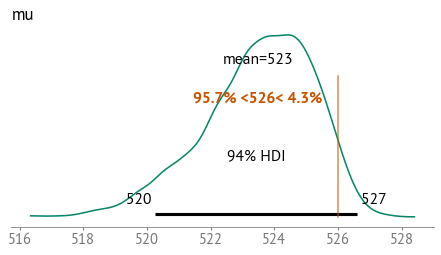

In [56]:
az.plot_posterior(idata, var_names=['mu'], ref_val=true_mu)
decorate()
plt.savefig("selection_bias30.png", dpi=300)

The estimate of `sigma` is a little high.

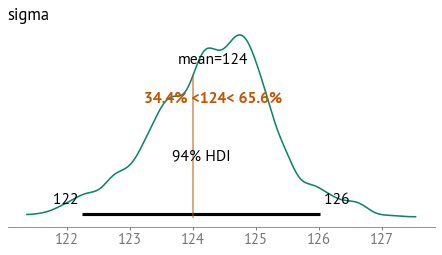

In [57]:
az.plot_posterior(idata, var_names=['sigma'], ref_val=true_sigma)
decorate()
plt.savefig("selection_bias31.png", dpi=300)

And the estimate of `beta` is a little high, but the HDI covers the true value.

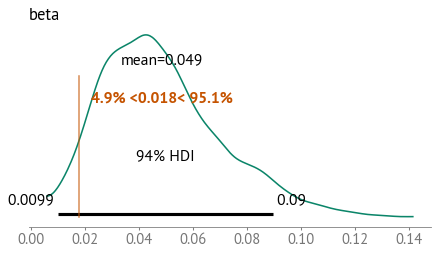

In [58]:
az.plot_posterior(idata, var_names=['beta'], ref_val=true_beta)
decorate()
plt.savefig("selection_bias32.png", dpi=300)

The parameter recovery test is pretty good.

But with data from only a single year, we can't be confident in the estimates, in part because the selection parameter and the perturbations compete to explain the shape of the distribution.
That's why we need a hierarchical model.

## Hierarchical

A hierarchical model makes it possible to share information between years and sexes.
In particular, recall that the distribution of scores appears to be different between sexes but consistent from year to year.
And the perturbations in the distribution of scores appear to be different from year to year but consistent between sexes.
The hierarchical model can take advantage of these consistencies.

We'll keep the parameters of the selection model unpooled, so we estimate values separately for each combination of year and sex.

First let's get the data into shape for the hierarchical model.

In [59]:
def get_counts_obs(year, sex):
    return df_map[year].loc[thetas, sex]

In [60]:
years = [2011, 2012, 2013, 2014, 2015]
sexes = ['Male', 'Female']

count_array = np.array([
    [get_counts_obs(year, sex=sex) for sex in sexes]
    for year in years
])

count_array.shape  # (n_years, n_sexes, n_scores)

(5, 2, 61)

In [61]:
N_test_array = count_array.sum(axis=2)
N_test_array

array([[770605, 876518],
       [778142, 886337],
       [776092, 883955],
       [783570, 888825],
       [794802, 903719]])

We'll define coordinates for the various dimensions, which makes the model easier to read and validate.

In [62]:
coords = {
    'year': years,
    'sex': sexes,
    'full_score': full_thetas,    # 81
    'score': thetas_centered,     # 61
}

Here's the hierarchical model.

Note one difference from the simple model: `log_noise` is drawn from a ZeroSumNormal rather than the diff of an array of Normals.
That means it might be a less realistic model of the data-generating process, but it doesn't seem to hurt the results.


In [63]:
with pm.Model(coords=coords) as model:
    # Data
    counts_pt = pm.Data("counts", count_array, dims=("year", "sex", "score"))
    N_test_pt = pm.Data("N_test", N_test_array, dims=("year", "sex"))

    # Population distribution parameters per sex
    mu = pm.Normal("mu", mu=500, sigma=30, dims="sex")
    sigma = pm.Gamma("sigma", **sigma_params, dims="sex")
    
    # Parameters of the selection functions
    beta = pm.Gamma("beta", **beta_params, dims=["year", "sex"])

    # Base log-probability from the Normal distribution (sex, full_score)
    log_pdf = pm.logp(pm.Normal.dist(mu=mu[:, None], 
                                     sigma=sigma[:, None]), 
                                     full_thetas[None, :])  

    # Generate noise
    sigma_noise = pm.Gamma("sigma_noise", **sigma_noise_params)
    log_noise_raw = pm.ZeroSumNormal("log_noise_raw", sigma=sigma_noise, 
                                     dims=["year", "score"])
    
    # --- Detrend log_noise along the score axis (per year) ---
    x = thetas_scaled                        # shape: (score,)
    x2_sum = pm.math.sum(x * x)              # scalar
    slope = pm.math.sum(log_noise_raw * x[None, :], axis=-1) / x2_sum   # shape: (year,)
    log_noise = pm.Deterministic(
        "log_noise",
        log_noise_raw - slope[:, None] * x[None, :]
    )
    
    zeros = pt.zeros((len(years), len(full_thetas)))
    log_noise_full = pt.inc_subtensor(zeros[:, center_mask], log_noise)
    
    # Add noise to log_pdf, broadcast to (year, sex, full_score)
    perturbed_log_pdf = log_pdf[None, :, :] + log_noise_full[:, None, :]

    # Convert to probabilities (year, sex, full_score)
    normalizer = pm.math.logsumexp(perturbed_log_pdf, axis=-1, keepdims=True)
    pdf = pm.Deterministic("pdf", pm.math.exp(perturbed_log_pdf - normalizer))  
                
    # Compute center_pdf and add tail masses
    left_mass = pdf[:, :, left_mask].sum(axis=-1)    # (year, sex)
    right_mass = pdf[:, :, right_mask].sum(axis=-1)  # (year, sex)
    center_pdf = pdf[:, :, center_mask]              # (year, sex, score)

    center_pdf = pt.inc_subtensor(center_pdf[:, :, 0], left_mass)
    center_pdf = pt.inc_subtensor(center_pdf[:, :, -1], right_mass)

    # Selection model
    logits = beta[:, :, None] * thetas_scaled[None, None, :]  # (year, sex, score)
    p_take = pm.Deterministic("p_take", pm.math.sigmoid(logits))

    # Test-taker distribution
    test_unnorm = center_pdf * p_take
    prob_test = test_unnorm.sum(axis=-1)
    test_pdf = pm.Deterministic("test_pdf", test_unnorm / test_unnorm.sum(axis=-1, keepdims=True))

    # Multinomial likelihood for score bins
    pm.Multinomial("obs_bins", n=N_test_pt, p=test_pdf, observed=counts_pt,
                   dims=["year", "sex", "score"])

In [64]:
with model:
    idata = pm.sample(target_accept=0.8, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, beta, sigma_noise, log_noise_raw]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 142 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [65]:
# Save InferenceData to file for later analysis (e.g., LOO analysis)
# This allows us to perform additional analyses without re-running the model
idata.to_netcdf("selection_bias3_idata.nc")

'selection_bias3_idata.nc'

The model samples well and the diagnostics look good.

In [66]:
pm.summary(idata, var_names=['mu', 'sigma', 'beta', 'sigma_noise'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[Male],507.563,1.339,505.163,510.198,0.067,0.049,403.0,575.0,1.02
mu[Female],502.071,0.263,501.541,502.521,0.017,0.010,224.0,515.0,1.03
sigma[Male],118.518,0.543,117.468,119.486,0.120,0.028,20.0,77.0,1.16
sigma[Female],109.939,0.366,109.288,110.582,0.101,0.027,14.0,46.0,1.24
"beta[2011, Male]",0.394,0.020,0.357,0.432,0.001,0.001,396.0,587.0,1.02
"beta[2011, Female]",0.029,0.005,0.020,0.038,0.000,0.000,365.0,715.0,1.01
"beta[2012, Male]",0.419,0.020,0.379,0.454,0.001,0.001,408.0,568.0,1.02
"beta[2012, Female]",0.025,0.005,0.015,0.035,0.001,0.000,97.0,493.0,1.05
"beta[2013, Male]",0.398,0.020,0.359,0.435,0.001,0.001,399.0,626.0,1.02
"beta[2013, Female]",0.048,0.005,0.038,0.058,0.000,0.000,305.0,624.0,1.02


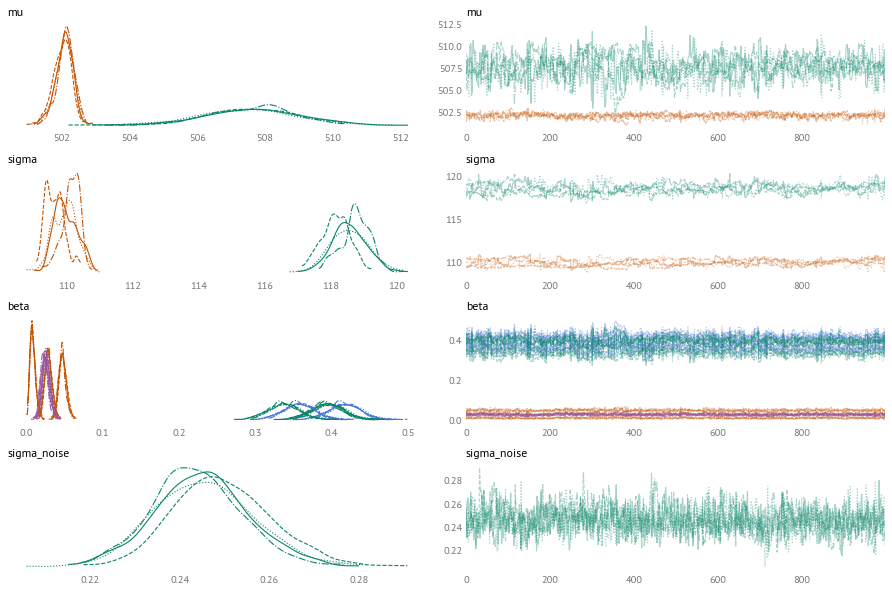

In [67]:
pm.plot_trace(idata, var_names=['mu', 'sigma', 'beta', 'sigma_noise'])
decorate()

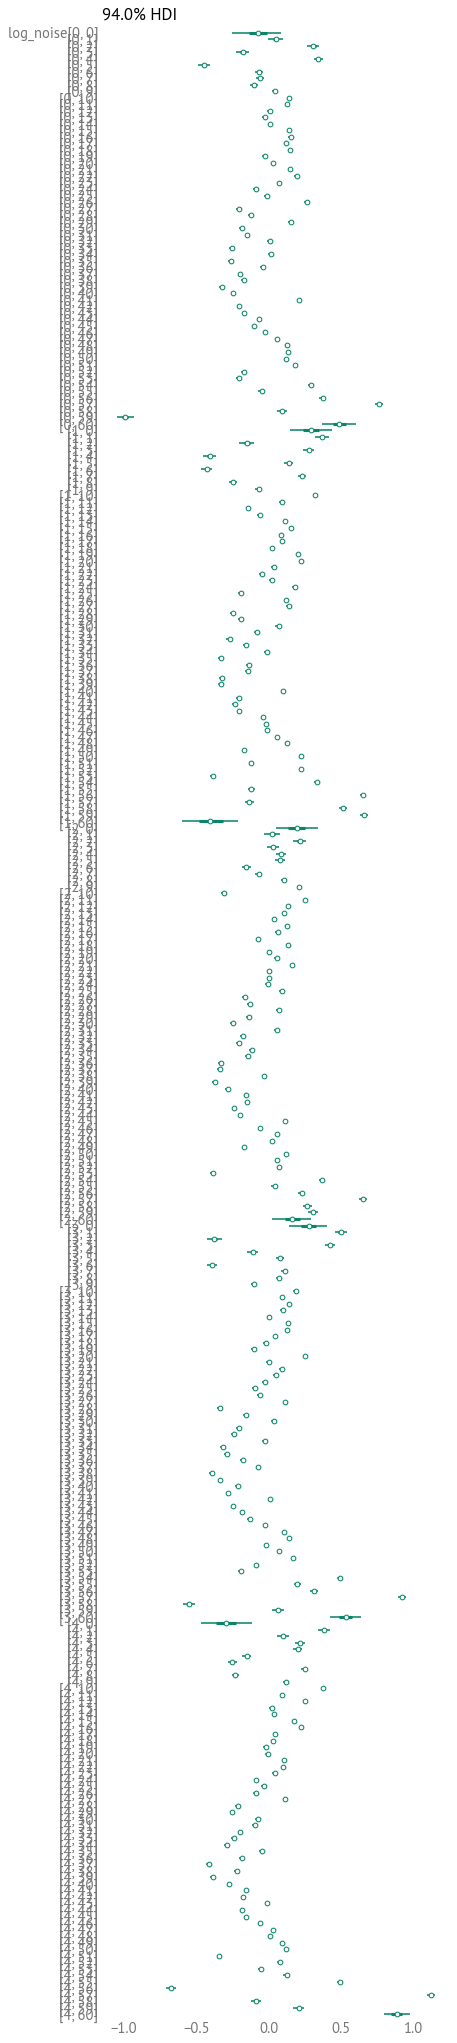

In [68]:
az.plot_forest(idata, var_names='log_noise', combined=True);

Here are the posterior distributions.

In [69]:
def plot_two_posteriors(idata, varname):
    ax = plt.gca()
    az.plot_posterior(idata.posterior[varname].sel(sex="Male"), 
                      ax=ax, hdi_prob='hide', color="C0", label="Male")
    az.plot_posterior(idata.posterior[varname].sel(sex="Female"), 
                      ax=ax, hdi_prob='hide', color="C1", label="Female")
    decorate()

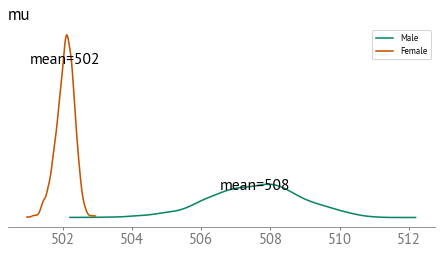

In [70]:
plot_two_posteriors(idata, "mu")
plt.savefig("selection_bias33.png", dpi=300)

The posterior means of the `mu` parameters are 510 and 502, a difference of only 8 points, compared to the 31-34 point difference seen in the mean test scores.

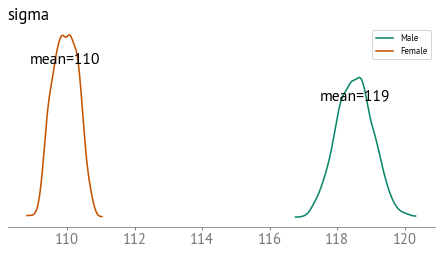

In [71]:
plot_two_posteriors(idata, "sigma")
plt.savefig("selection_bias34.png", dpi=300)

The estimated standard deviation is considerably higher for males.

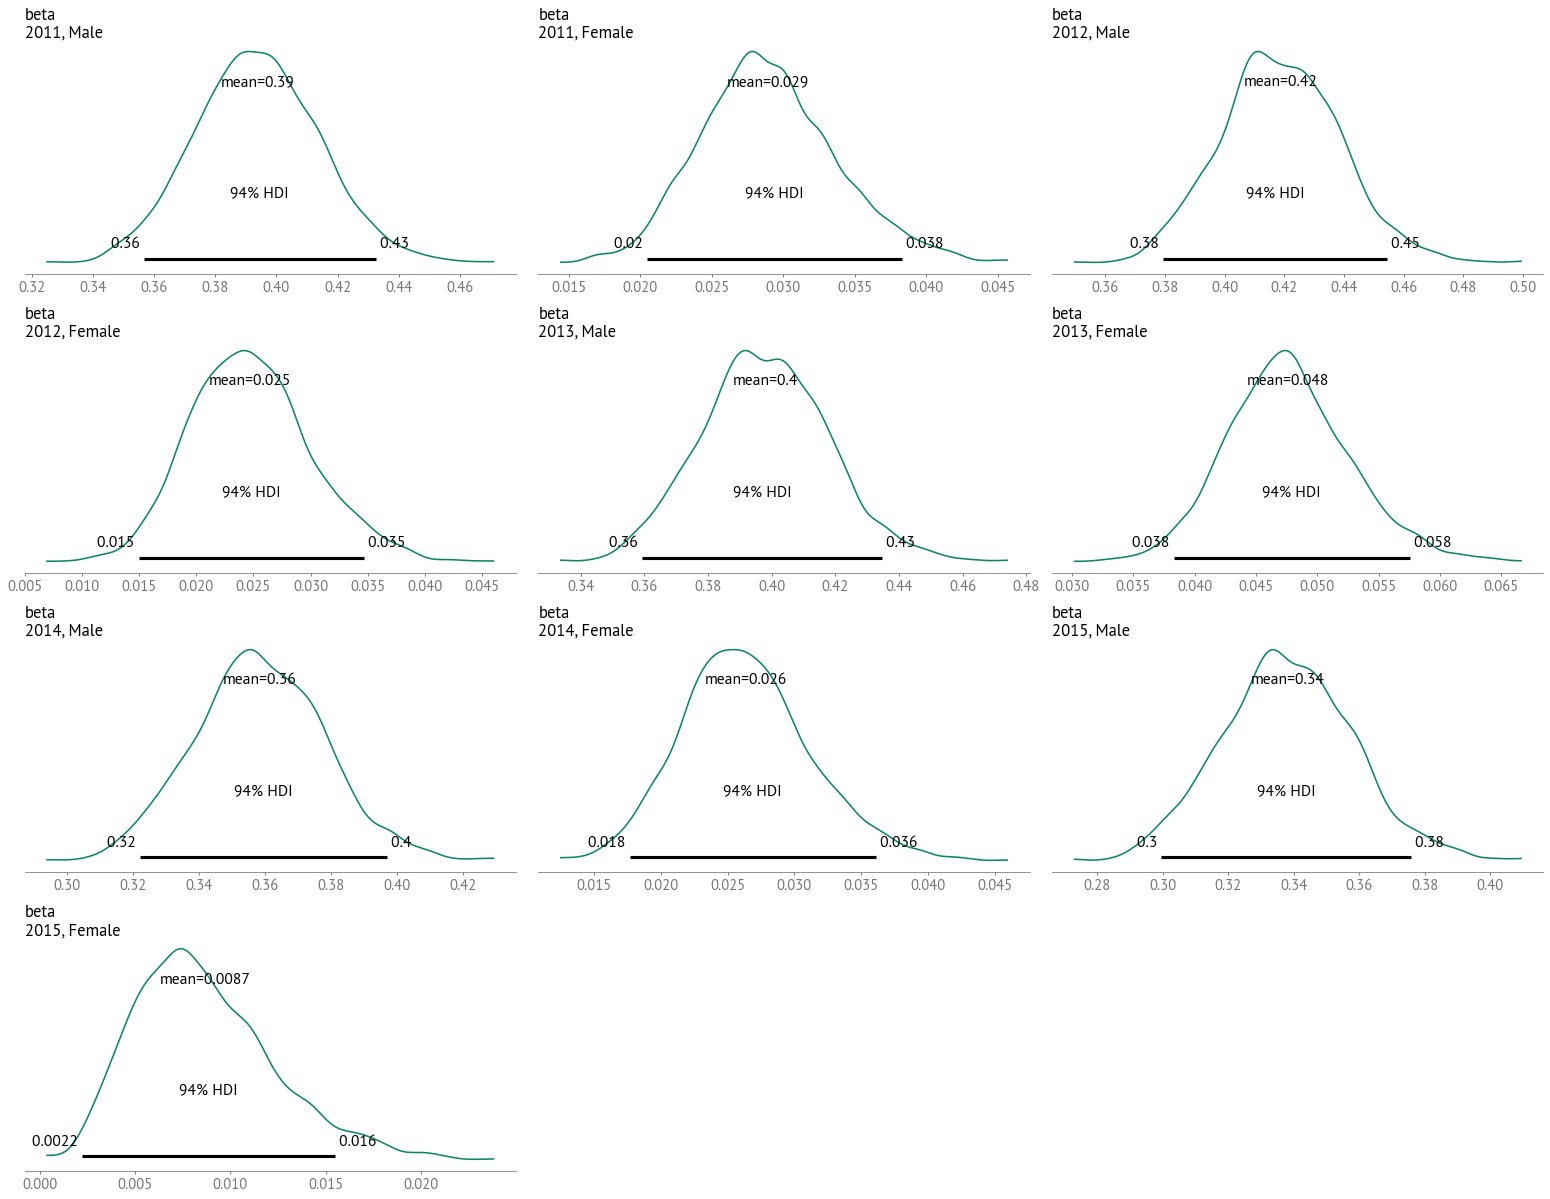

In [72]:
pm.plot_posterior(idata, var_names=['beta'])
decorate()

Here are the estimated selection functions for male test-takers.
They are consistent from year to year, and show a strong selection effect.

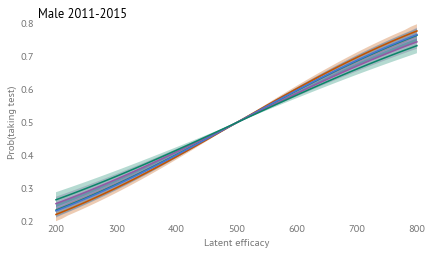

In [73]:
for year in years:
    idata_one = idata.sel(year=year, sex="Male")
    plot_selection_function(idata_one, None, thetas_scaled)
    
ylim = [0.2, 0.8]
decorate(xlabel='Latent efficacy', ylabel='Prob(taking test)', 
         title='Male 2011-2015', ylim=ylim)
plt.savefig("selection_bias38.png", dpi=300)

Here are the estimated selection functions for female test-takers.
They are reasonably consistent from year to year, and show a much weaker selection effect.

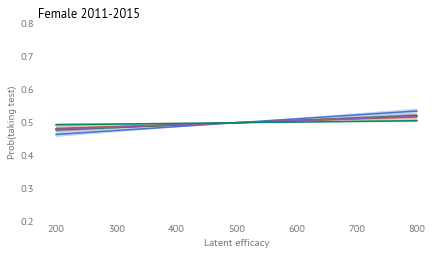

In [74]:
for year in years:
    idata_one = idata.sel(year=year, sex="Female")
    plot_selection_function(idata_one, None, thetas_scaled)
    
decorate(xlabel='Latent efficacy', ylabel='Prob(taking test)', 
         title='Female 2011-2015', ylim=ylim)
plt.savefig("selection_bias39.png", dpi=300)

If we generate a sample from the posterior predictive distribution, we can confirm that the score distributions are similar to the observed data.

In [75]:
with model:
    post_pred = pm.sample_posterior_predictive(idata)

Sampling: [obs_bins]


Output()

In [76]:
obs_bins_post_pred = az.extract(post_pred, group='posterior_predictive')['obs_bins']
obs_bins_post_pred.shape

(5, 2, 61, 4000)

In [77]:
medians = np.median(obs_bins_post_pred, axis=-1)
medians.shape

(5, 2, 61)

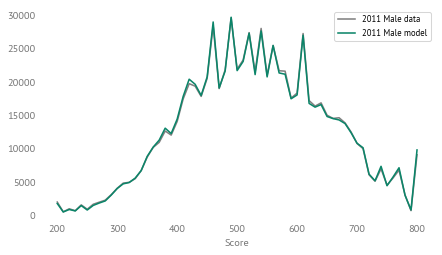

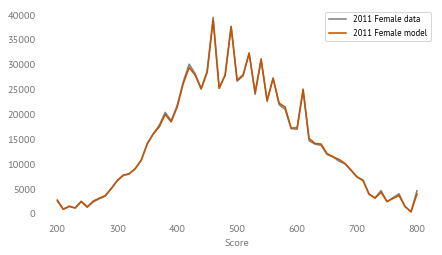

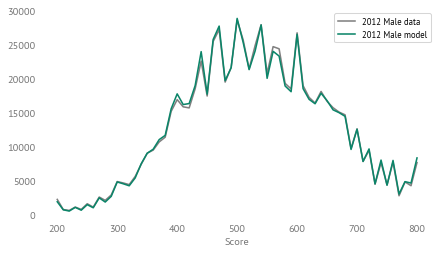

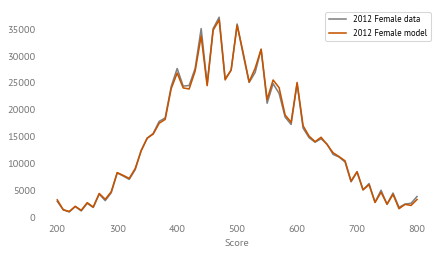

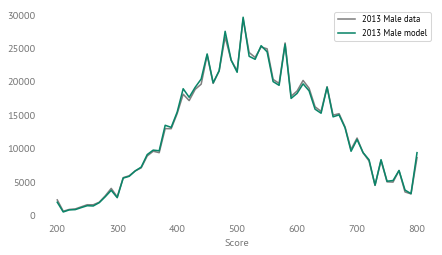

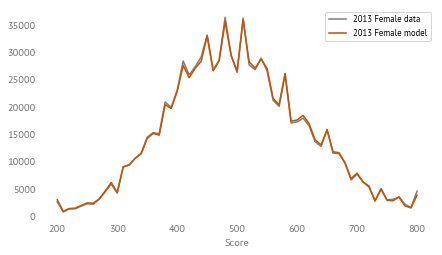

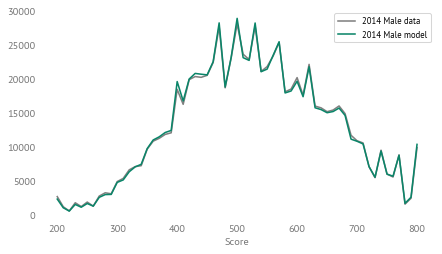

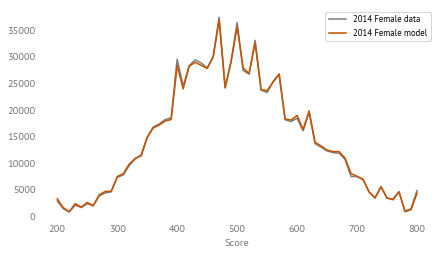

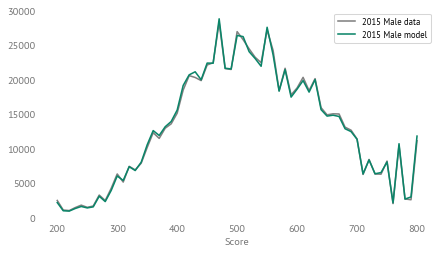

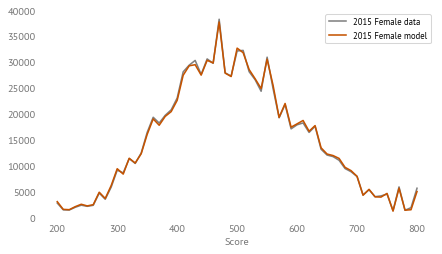

In [78]:
for i, year in enumerate(years):
    for j, sex in enumerate(sexes):
        plt.figure()
        df_map[year][sex].plot(color='gray', label=f'{year} {sex} data')
        plt.plot(thetas, medians[i, j], color=color_map[sex], label=f'{year} {sex} model')
        decorate()

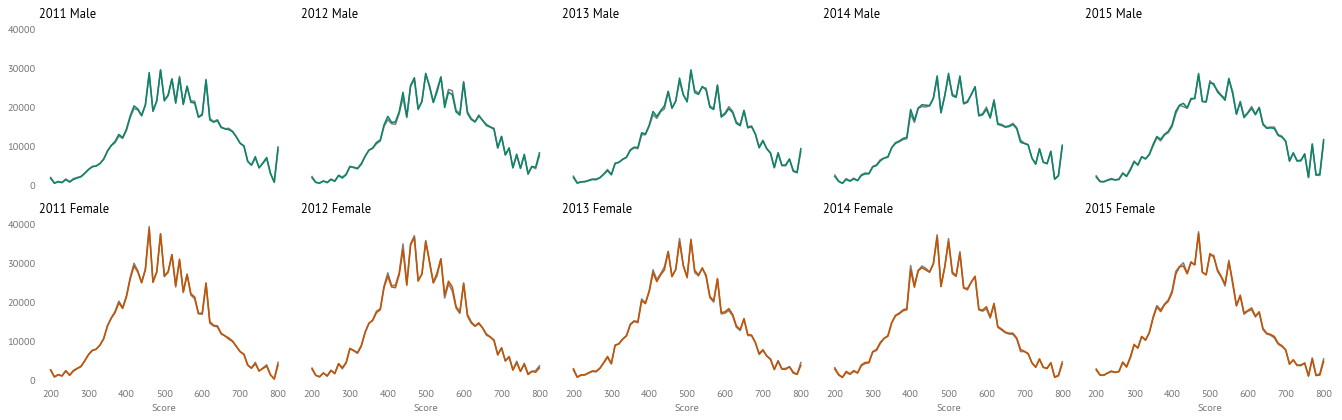

In [79]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 6), sharex=True, sharey=True)

for i, year in enumerate(years):
    for j, sex in enumerate(sexes):
        ax = axes[j, i]   # row = sex index, col = year index
        
        df_map[year][sex].plot(ax=ax, color='gray', label=f'{year} {sex} data')
        ax.plot(thetas, medians[i, j], color=color_map[sex], label=f'{year} {sex} model')
        
        plt.sca(ax)
        decorate(title=f'{year} {sex}', legend=False)
        
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("selection_bias40.png",dpi=300)

These results depend strongly on the assumption that the latent distribution of efficacy is Gaussian -- if the distribution of scores is skewed, that is taken to imply a selection effect.
We can't rule out the possibility that the underlying distribution is truly skewed.

The results are also sensitive to a free parameter of the model, the amount of deviation from a normal distribution that can be attributed to the quirks of SAT scoring.
We have set this parameter to the lowest value that allows the model to reproduce the quirks without obscuring the effects we are interested in: selection bias and differences in the latent distributions for males and females.

So we should probably not take the estimated selection functions too seriously.
For example, the selection functions for males suggest that someone with the efficacy to score 800 is 2-3 times more likely to take the SAT that someone whose expected score is 200.
It's hard to say whether that's realistic.

However, the results of the hierarchical model provide strong evidence that:

* The selection effect is substantially stronger for males than females, and

* The difference in selection effects could explain a large part of the observed difference in scores between male and female test-takers.

While the difference in scores is consistently 31-34 points, the difference in average efficacy might be only 8 points.